In [2]:
import os
import json
import numpy as np

# read ground truth data

In [5]:
groud_truth_file_path = 'Xin-black-attack-simba/result_black_simba.json'
# groud_truth_file_path = 'Xin-black-attack-simba/result_black_simba——effnet.json'
PATH = './imgs/'

In [6]:
def extract_ground_truth(img_file_path):
    l2_norm = image_data[img_file_path]["l2_norm"]
    queries = image_data[img_file_path]["queries:"]
    gt = np.array([l2_norm, queries]).reshape(1, -1)
    return gt

In [7]:
all_ground_truth = []
with open(groud_truth_file_path, 'r') as groud_truth_file:
    groud_truth_data = json.load(groud_truth_file)
    for root, ds, fs in os.walk(PATH):
        for file in fs:
            img_dataset, img_class = root.replace(PATH, '').split('\\')
            img_path = os.path.join(root, file).replace('\\', '/')
            
            exist_check = groud_truth_data.get(img_path)
            if exist_check is not None:
                l2_norm = groud_truth_data[img_path]["l2_norm"]
                queries = groud_truth_data[img_path]["queries:"]
                gt = np.array([l2_norm, queries]).reshape(1, -1)
            else:
                gt = np.array([None, None]).reshape(1, -1)
            if len(all_ground_truth) == 0:
                all_ground_truth = gt
            else:
                all_ground_truth = np.vstack((all_ground_truth, gt))     

In [8]:
all_ground_truth.shape

(50000, 2)

# concatenate all features

In [9]:
json_folder_path = 'img_features_json/'

In [10]:
# img_features_list = [
#     'Color_Histogram', 'Color_Moment', 'Dominant_Color_Descriptor',
#     'Gray_Level_Cooccurrence_Matrix', 'Local_Binary_Patterns', 'Gabor_Filters',
#     'Histogram_of_Oriented_Gradients', 'Sobel', 'Prewitt', 'Canny',
#     'Laplacian_of_Gaussian_Filter', 'Entropy', 'Fractal_Dimension',
#     'Edge_Density', 'Spatial_Information', 'Discrete_Fourier_Transform',
#     'Wavelet_Transform', 'Histogram_Equalization', 'Discrete_Cosine_Transform',
#     'SVD', 'PCA_transform'
# ]

img_features_list = [
    'Color_Moment', 'Local_Binary_Patterns', 'Gabor_Filters',
    'Histogram_of_Oriented_Gradients', 'Entropy', 'Fractal_Dimension',
    'Edge_Density', 'Spatial_Information'
]

In [11]:
def extract_features(file_path, feature_name):
    with open(file_path, 'r') as file:
        data = json.load(file)
        features = []
        for image_data in data.values():
            feature = image_data['METRICS'][feature_name]
            features.append(np.array(feature).reshape(-1, ))
        return features

In [15]:
all_features = []
for feature_name in img_features_list[:2]:
    filename = feature_name + '.json'
    file_path = os.path.join(json_folder_path, filename)
    print(file_path)
    features = extract_features(file_path, feature_name)
    if len(all_features) == 0:
        all_features = features
    else:
        all_features = np.concatenate((all_features, features), axis = 1)


img_features_json/Color_Moment.json
img_features_json/Local_Binary_Patterns.json


# Split training and testing sets

In [17]:
all_features_ = all_features[all_ground_truth[:, 0] != None]
all_ground_truth_ = all_ground_truth[:, :][all_ground_truth[:, 0] != None]

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(all_features_, all_ground_truth_, test_size = 0.3, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(4064, 409) (1742, 409) (4064, 2) (1742, 2)


In [84]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
normalized_X_train = scaler.fit_transform(X_train)
normalized_X_test = scaler.transform(X_test)

In [222]:
quantile_01 = np.quantile(y_train, 0.1, axis = 0)
y_train_01_quantile = np.zeros(y_train.shape)
y_train_01_quantile[:, 0] = y_train[:, 0] <= quantile_01[0]
y_train_01_quantile[:, 1] = y_train[:, 1] <= quantile_01[1]
y_train_01_quantile

array([[0., 0.],
       [1., 0.],
       [0., 0.],
       ...,
       [1., 1.],
       [0., 0.],
       [0., 0.]])

<Axes: >

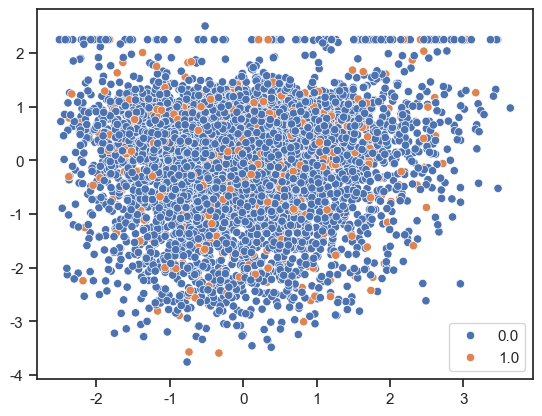

In [223]:
import seaborn as sns
sns.scatterplot(x = normalized_X_train[:, 0], y = normalized_X_train[:, 130], hue = y_train_01_quantile[:, 0])

# LASSO

In [186]:
from sklearn.linear_model import LinearRegression, Lasso
model1 = Lasso(alpha = 0.01)
model1.fit(normalized_X_train, y_train[:, 0])
coefficients1 = model1.coef_
intercept1 = model1.intercept_
print("Coefficients_for_l2norm:", len(coefficients1[coefficients1!=0]))

Coefficients_for_l2norm: 281


In [189]:
model2 = Lasso(alpha = 5)
model2.fit(normalized_X_train, y_train[:, 1])
coefficients2 = model2.coef_
intercept2 = model2.intercept_
print("Coefficients_for_queries:", len(coefficients2[coefficients2!=0]))

Coefficients_for_queries: 392
